# Purchase Journey Analysis

This notebook focuses on users who eventually make a purchase, analyzing all their sessions leading up to that purchase event using previously defined categories.

In [50]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

# Load the same dataset as in sessions_deepdive.ipynb
df = pd.read_csv('analytics.csv')

# Set the same colors as in the original notebook for consistency
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']
facecolor = '#F5F5F5'

In [51]:
# Clean the data and filter relevant entries
# Remove entries without user_id or with placeholder user_ids
df_filtered = df[(df['user_id'] != 'none') & (df['user_id'] != 'less-website')].copy()

# Convert timestamp strings to datetime objects
df_filtered['timestamp'] = pd.to_datetime(df_filtered['created_at'], format='ISO8601')

# Define purchase event indicators
purchase_event_types = ['enforce_wait_modal_shown']

# Function to check if an event type indicates a purchase
def is_purchase_event(event_type):
    # Check for exact matches
    if event_type in purchase_event_types:
        return True
    
    # Check for partial matches in case the naming convention varies
    for purchase_type in purchase_event_types:
        if purchase_type.lower() in event_type.lower():
            return True
    
    return False

# Add a column to identify purchase events
df_filtered['is_purchase'] = df_filtered['type'].apply(is_purchase_event)

# Define the other event types we're interested in
df_filtered['is_add_to_cart'] = df_filtered['type'] == 'add-to-cart'
df_filtered['is_checkout'] = df_filtered['type'] == 'checkout'

In [52]:
# Process sessions similar to the original notebook
session_groups = df_filtered.groupby('session_id')

# Extract session start times, end times, duration, and whether each session contains a purchase
session_data = []
for session_id, session_df in session_groups:
    # Skip sessions with invalid or placeholder IDs
    if session_id == 'none' or pd.isna(session_id):
        continue
        
    # Sort session events by timestamp
    session_df = session_df.sort_values('timestamp')
    
    # Get user_id (assuming it's consistent within a session)
    user_id = session_df['user_id'].iloc[0] if not session_df.empty else None
    
    # Get session start and end times
    start_time = session_df['timestamp'].min()
    end_time = session_df['timestamp'].max()
    
    # Calculate session duration in minutes
    duration_minutes = (end_time - start_time).total_seconds() / 60
    
    # Check for each event type - ensuring uniqueness per session by using .any()
    has_add_to_cart = session_df['is_add_to_cart'].any()
    has_checkout = session_df['is_checkout'].any()
    has_purchase = session_df['is_purchase'].any()
    
    # Find timestamps for FIRST occurrence of each event type
    add_to_cart_time = session_df[session_df['is_add_to_cart']]['timestamp'].min() if has_add_to_cart else None
    checkout_time = session_df[session_df['is_checkout']]['timestamp'].min() if has_checkout else None
    purchase_time = session_df[session_df['is_purchase']]['timestamp'].min() if has_purchase else None
    
    # Determine event sequence order based on first occurrences
    event_order = []
    if has_add_to_cart:
        event_order.append(('add_to_cart', add_to_cart_time))
    if has_checkout:
        event_order.append(('checkout', checkout_time))
    if has_purchase:
        event_order.append(('purchase', purchase_time))
    
    # Sort events by timestamp
    event_order.sort(key=lambda x: x[1])
    
    # Extract the ordered sequence of event types
    event_sequence = [event[0] for event in event_order]
    event_sequence_str = ' → '.join(event_sequence) if event_sequence else 'no_events'
    
    # Collect relevant session details
    session_data.append({
        'session_id': session_id,
        'user_id': user_id,
        'start_time': start_time,
        'end_time': end_time,
        'duration_minutes': duration_minutes,
        'has_add_to_cart': has_add_to_cart,
        'has_checkout': has_checkout,
        'has_purchase': has_purchase,
        'event_sequence': event_sequence_str,
        'event_count': len(session_df)
    })

# Create DataFrame from collected session data
sessions_df = pd.DataFrame(session_data)

# Add flow categorization
def categorize_flow(row):
    # Complete flow
    if row['has_add_to_cart'] and row['has_checkout'] and row['has_purchase']:
        return 'Complete Flow'
    
    # Add to cart then checkout
    elif row['has_add_to_cart'] and row['has_checkout'] and not row['has_purchase']:
        return 'Add-to-Cart then Checkout'
    
    # Checkout then purchase
    elif not row['has_add_to_cart'] and row['has_checkout'] and row['has_purchase']:
        return 'Checkout then Purchase'
    
    # Just add to cart
    elif row['has_add_to_cart'] and not row['has_checkout'] and not row['has_purchase']:
        return 'Add-to-Cart'
    
    # Just checkout
    elif not row['has_add_to_cart'] and row['has_checkout'] and not row['has_purchase']:
        return 'Checkout'
    
    # Just purchase (unusual but possible)
    elif not row['has_add_to_cart'] and not row['has_checkout'] and row['has_purchase']:
        return 'Direct Purchase'
    
    # Just looking
    else:
        return 'Just Looking'

# Apply the flow categorization
sessions_df['flow_category'] = sessions_df.apply(categorize_flow, axis=1)

# Add the simpler categorization as well
def categorize_session(row):
    if not row['has_purchase']:
        return 'Just Looking'
    elif row['duration_minutes'] >= 20:
        return 'Looking Then Purchasing'
    else:
        return 'Quick Purchase'

sessions_df['category'] = sessions_df.apply(categorize_session, axis=1)

# Show basic statistics
print(f"Total sessions: {len(sessions_df)}")
print(f"Sessions with purchases: {sessions_df['has_purchase'].sum()}")
print(f"Unique users: {sessions_df['user_id'].nunique()}")
users_with_purchases = sessions_df[sessions_df['has_purchase']]['user_id'].nunique()
print(f"Users with at least one purchase: {users_with_purchases}")
print(f"Percentage of users who made purchases: {users_with_purchases / sessions_df['user_id'].nunique() * 100:.2f}%")

Total sessions: 136
Sessions with purchases: 10
Unique users: 36
Users with at least one purchase: 7
Percentage of users who made purchases: 19.44%


## Identifying Users Who Eventually Purchase

Now we'll identify all users who made at least one purchase, and for these users, we'll analyze all their sessions leading up to their first purchase.

In [53]:
# Identify users who made at least one purchase
purchasing_users = sessions_df[sessions_df['has_purchase']]['user_id'].unique()
print(f"Number of users who made at least one purchase: {len(purchasing_users)}")

# For each purchasing user, get all their sessions and sort by time
purchasing_user_sessions = sessions_df[sessions_df['user_id'].isin(purchasing_users)].copy()

# For each user, find their first purchase session
first_purchase_sessions = []
journey_to_purchase_data = []

for user_id in purchasing_users:
    # Get all sessions for this user
    user_sessions = purchasing_user_sessions[purchasing_user_sessions['user_id'] == user_id].sort_values('start_time')
    
    # Find the first purchase session for this user
    first_purchase_idx = user_sessions['has_purchase'].idxmax() if user_sessions['has_purchase'].any() else None
    
    if first_purchase_idx is not None:
        first_purchase_session = user_sessions.loc[first_purchase_idx]
        first_purchase_sessions.append(first_purchase_session)
        
        # Get all sessions before the first purchase
        pre_purchase_sessions = user_sessions[user_sessions['start_time'] < first_purchase_session['start_time']]
        
        # Add journey information
        journey_to_purchase_data.append({
            'user_id': user_id,
            'total_sessions_before_purchase': len(pre_purchase_sessions),
            'days_to_first_purchase': (first_purchase_session['start_time'] - user_sessions['start_time'].min()).total_seconds() / (60*60*24) if len(user_sessions) > 1 else 0,
            'first_purchase_session_id': first_purchase_session['session_id'],
            'first_purchase_category': first_purchase_session['category'],
            'first_purchase_flow': first_purchase_session['flow_category'],
            'pre_purchase_session_categories': pre_purchase_sessions['category'].tolist() if not pre_purchase_sessions.empty else [],
            'pre_purchase_flow_categories': pre_purchase_sessions['flow_category'].tolist() if not pre_purchase_sessions.empty else [],
            'pre_purchase_just_looking_count': sum(1 for cat in pre_purchase_sessions['category'] if cat == 'Just Looking'),
            'pre_purchase_add_to_cart_count': sum(1 for flow in pre_purchase_sessions['flow_category'] if 'Add-to-Cart' in flow),
            'pre_purchase_checkout_count': sum(1 for flow in pre_purchase_sessions['flow_category'] if 'Checkout' in flow)
        })

# Create DataFrame for journey analysis
journey_df = pd.DataFrame(journey_to_purchase_data)

# Show some statistics
print(f"Number of users with journey data: {len(journey_df)}")
print(f"Average sessions before first purchase: {journey_df['total_sessions_before_purchase'].mean():.2f}")
print(f"Median sessions before first purchase: {journey_df['total_sessions_before_purchase'].median():.2f}")
print(f"Average days to first purchase: {journey_df['days_to_first_purchase'].mean():.2f}")
print(f"Median days to first purchase: {journey_df['days_to_first_purchase'].median():.2f}")

journey_df.head()

Number of users who made at least one purchase: 7
Number of users with journey data: 7
Average sessions before first purchase: 1.14
Median sessions before first purchase: 1.00
Average days to first purchase: 1.88
Median days to first purchase: 0.03


,user_id,total_sessions_before_purchase,days_to_first_purchase,first_purchase_session_id,first_purchase_category,first_purchase_flow,pre_purchase_session_categories,pre_purchase_flow_categories,pre_purchase_just_looking_count,pre_purchase_add_to_cart_count,pre_purchase_checkout_count
0,e2eb1291-5fec-45e6-bded-3018f0d67d66,2,7.586985,031a7d76-2ef5-4006-9b28-6b401d6f1ae7,Quick Purchase,Checkout then Purchase,"[Just Looking, Just Looking]","[Just Looking, Just Looking]",2,0,0
1,1850b7a3-5cad-4d7b-a4a0-3c8dd534437d,3,1.489531,0b086918-2060-4c11-9e95-1b344570de8e,Quick Purchase,Complete Flow,"[Just Looking, Just Looking, Just Looking]","[Just Looking, Just Looking, Just Looking]",3,0,0
2,a8813899-eb7b-49f9-9e97-7f91f995e944,2,4.051127,c327e5af-1a82-4272-b393-0ef7f12c3b24,Quick Purchase,Checkout then Purchase,"[Just Looking, Just Looking]","[Checkout, Just Looking]",2,0,1
3,42e523b9-71a9-4304-938a-547e433bff6c,0,0.000000,9e00354a-d355-4df5-b2fc-76a218712eba,Looking Then Purchasing,Complete Flow,[],[],0,0,0
4,7e54f2ee-060a-467e-b319-9e99d8e58e27,0,0.000000,a58dfb42-0c53-4d83-bc7f-fc43adfc88cf,Looking Then Purchasing,Complete Flow,[],[],0,0,0


## Individual User Purchase Journey Visualization

To better understand the specific path users take before making a purchase, let's visualize individual user journeys. This will show us the sequence of session types that lead to a purchase event.

Found 7 users with interesting purchase journeys


/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_32171/4209852067.py:98: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


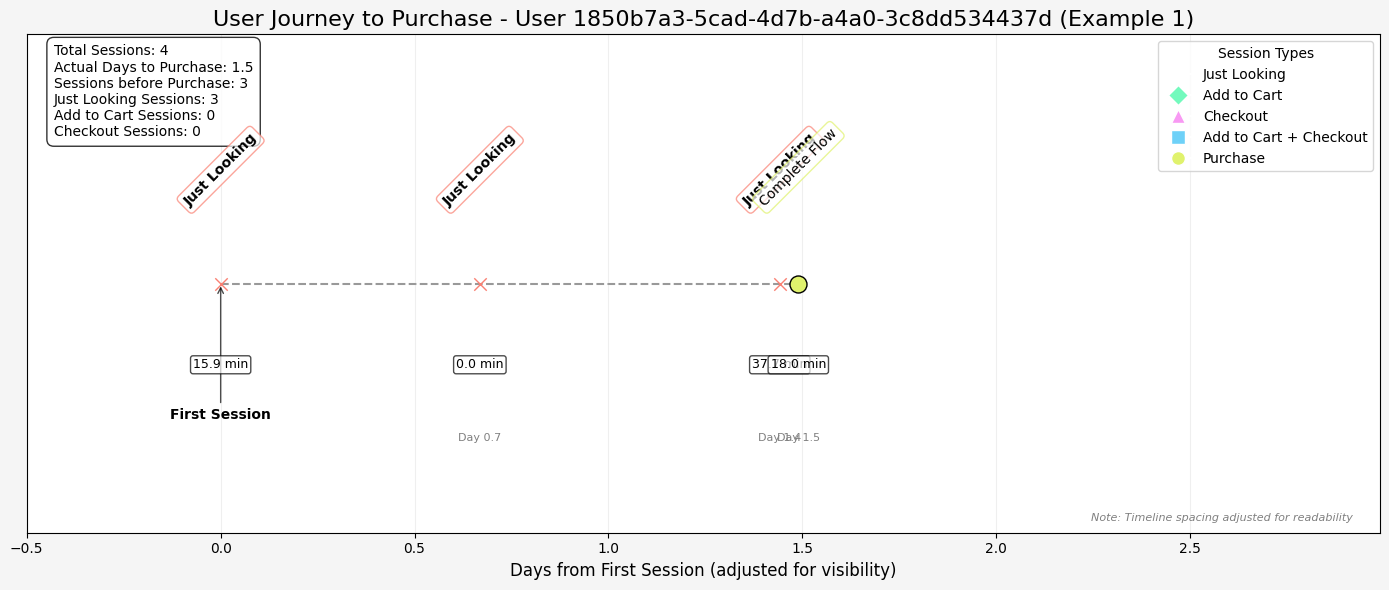

Journey Pattern for User 1850b7a3-5cad-4d7b-a4a0-3c8dd534437d:
Just Looking → Just Looking → Just Looking → Complete Flow (Purchase!)

--------------------------------------------------------------------------------



/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_32171/4209852067.py:98: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


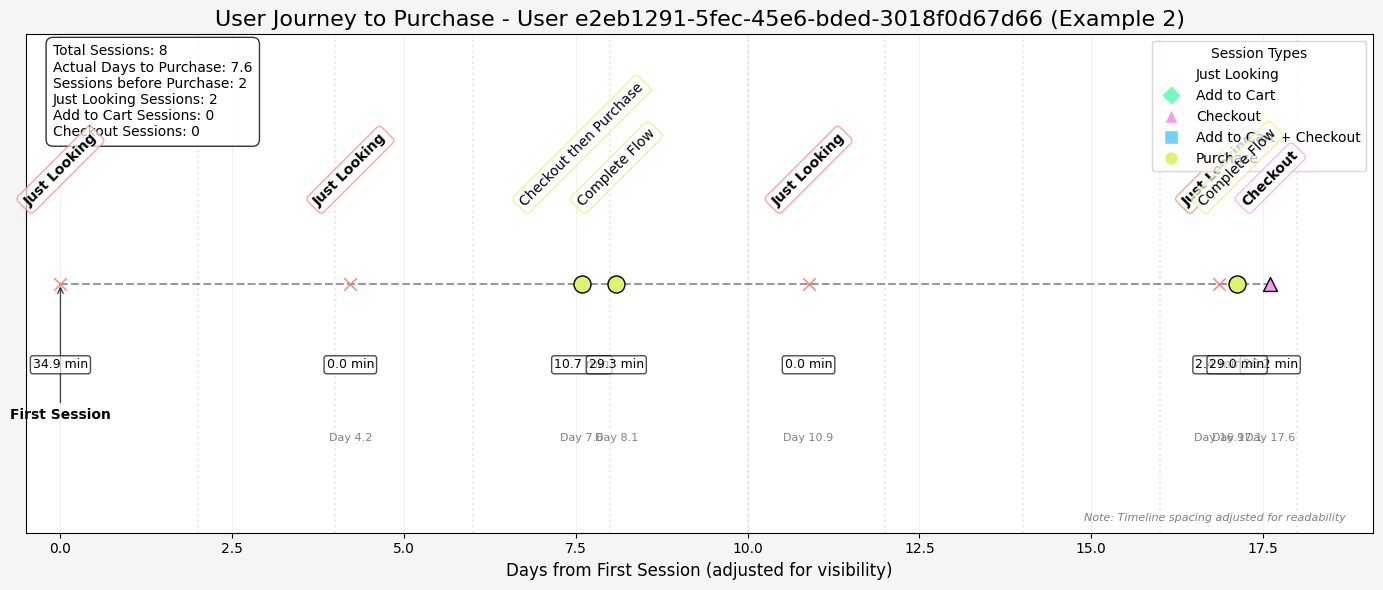

Journey Pattern for User e2eb1291-5fec-45e6-bded-3018f0d67d66:
Just Looking → Just Looking → Checkout then Purchase (Purchase!) → Complete Flow (Purchase!) → Just Looking → Just Looking → Complete Flow (Purchase!) → Checkout

--------------------------------------------------------------------------------



/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_32171/4209852067.py:98: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


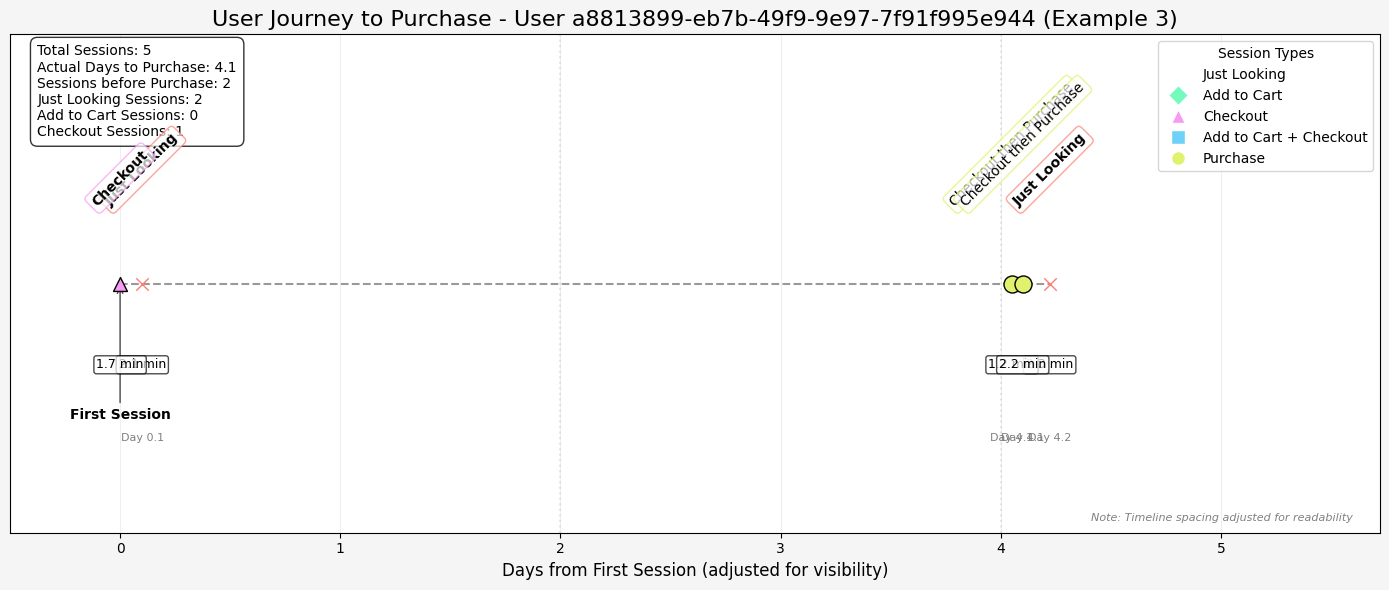

Journey Pattern for User a8813899-eb7b-49f9-9e97-7f91f995e944:
Checkout → Just Looking → Checkout then Purchase (Purchase!) → Checkout then Purchase (Purchase!) → Just Looking

--------------------------------------------------------------------------------



/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_32171/4209852067.py:98: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


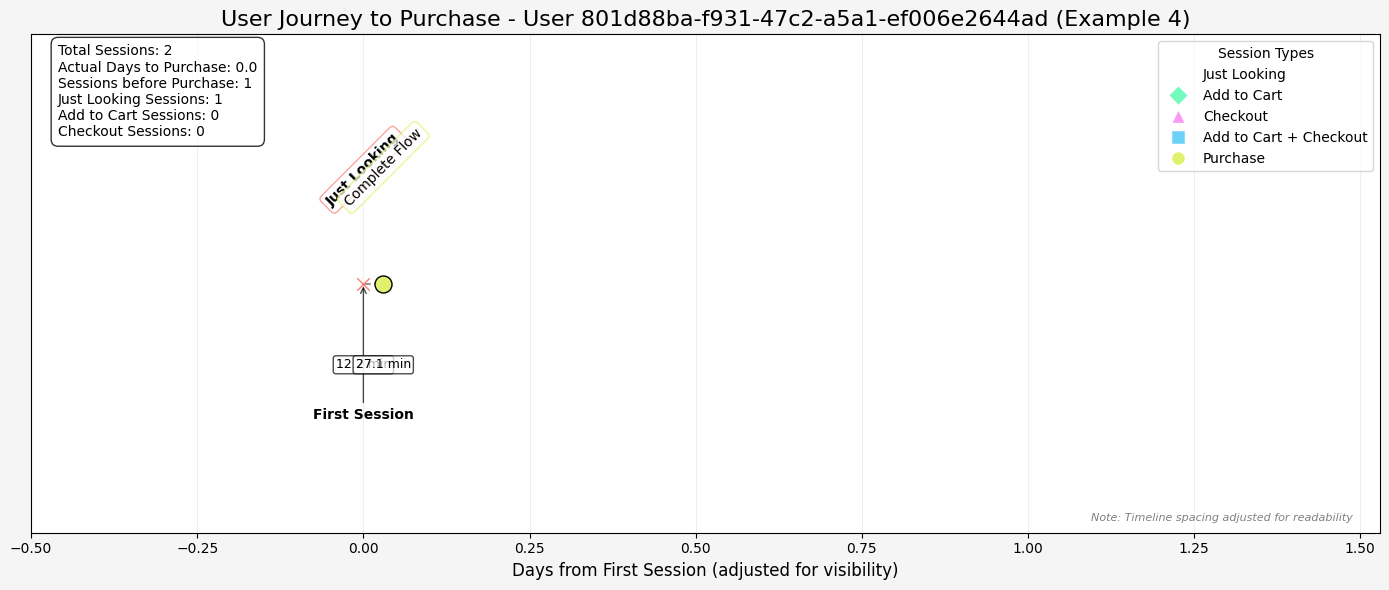

Journey Pattern for User 801d88ba-f931-47c2-a5a1-ef006e2644ad:
Just Looking → Complete Flow (Purchase!)

--------------------------------------------------------------------------------



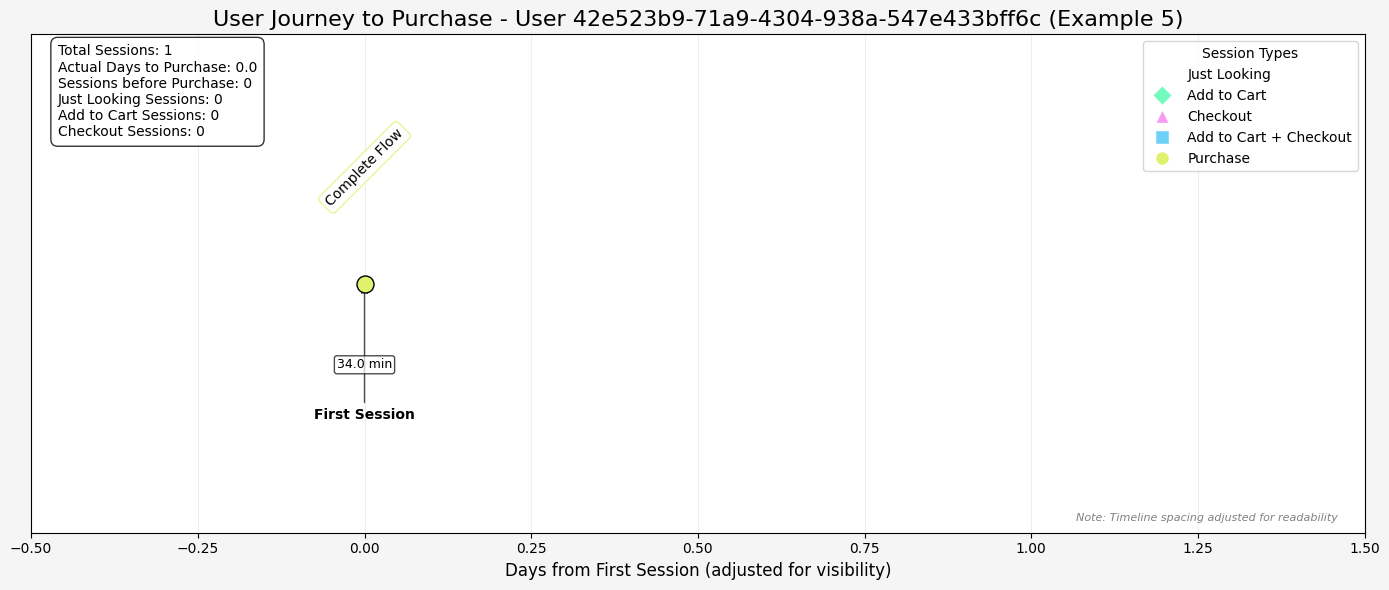

Journey Pattern for User 42e523b9-71a9-4304-938a-547e433bff6c:
Complete Flow (Purchase!)

--------------------------------------------------------------------------------



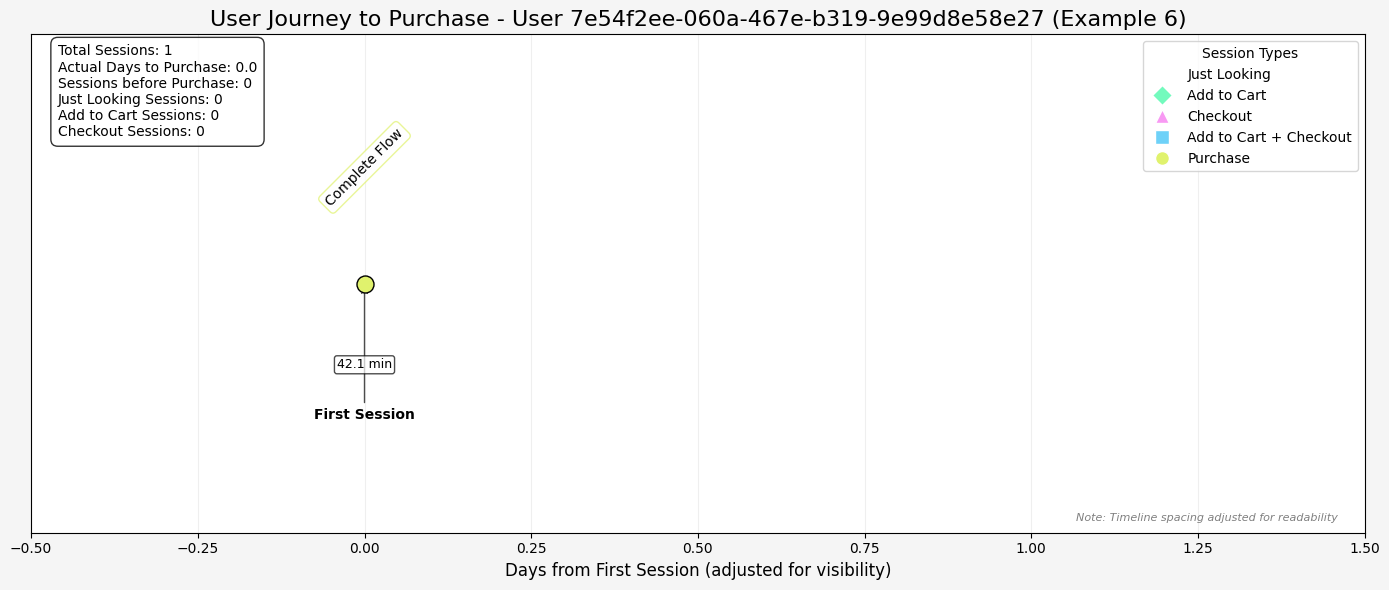

Journey Pattern for User 7e54f2ee-060a-467e-b319-9e99d8e58e27:
Complete Flow (Purchase!)

--------------------------------------------------------------------------------



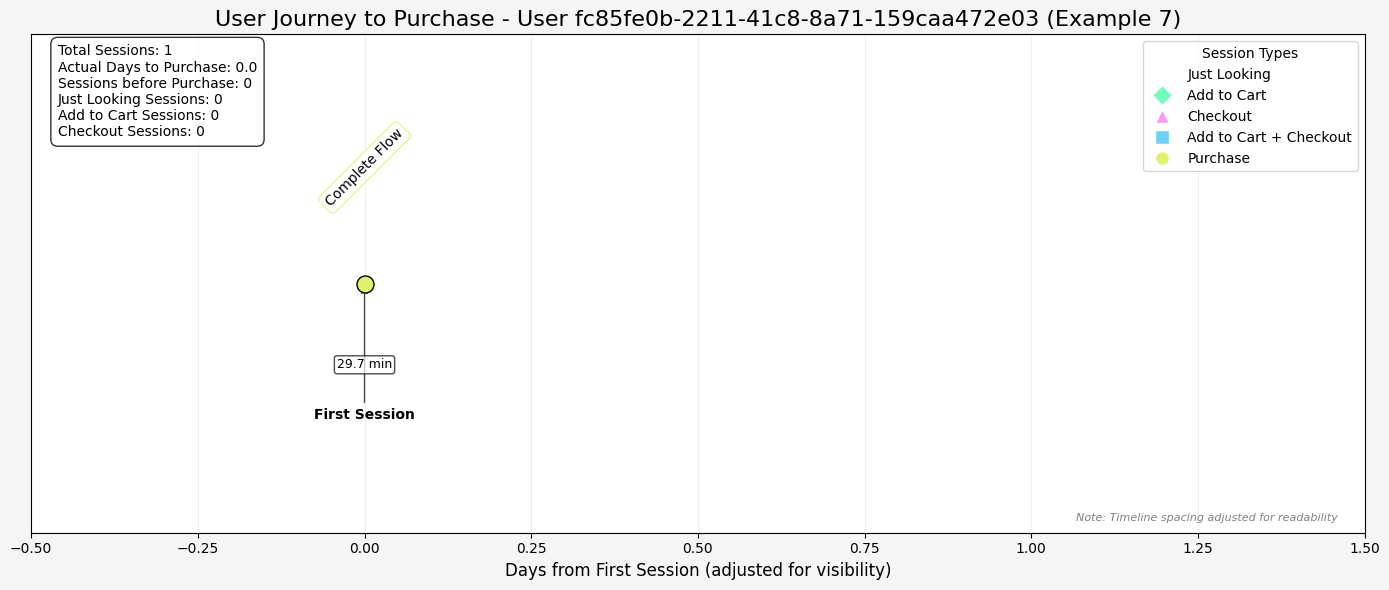

Journey Pattern for User fc85fe0b-2211-41c8-8a71-159caa472e03:
Complete Flow (Purchase!)

--------------------------------------------------------------------------------



In [54]:
# Select a few interesting users with multiple sessions before purchase for case studies
# We'll look for users with different patterns to show variety in purchase journeys

# Find users with multiple pre-purchase sessions (3+) for more interesting journeys
journey_examples = journey_df[journey_df['total_sessions_before_purchase'] >= 0].sort_values(
    by=['total_sessions_before_purchase', 'days_to_first_purchase'],
    ascending=[False, False]
).head(15)

if len(journey_examples) > 0:
    print(f"Found {len(journey_examples)} users with interesting purchase journeys")
    
    # Create a figure for each user's journey
    for i, (_, user_journey) in enumerate(journey_examples.iterrows()):
        user_id = user_journey['user_id']
        # Get all sessions for this user
        user_sessions = sessions_df[sessions_df['user_id'] == user_id].sort_values('start_time')
        
        # Find the first purchase session
        purchase_session = sessions_df[(sessions_df['session_id'] == user_journey['first_purchase_session_id'])]
        if purchase_session.empty:
            continue
            
        purchase_time = purchase_session['start_time'].iloc[0]
        
        # Prepare data for visualization
        timeline_data = []
        for _, session in user_sessions.iterrows():
            # Skip sessions with very low duration for better visualization
            # if session['duration_minutes'] < 0.1 and session['flow_category'] == 'Just Looking':
            #     continue

            # Calculate time from first session
            time_from_first = (session['start_time'] - user_sessions['start_time'].min()).total_seconds() / (60*60*24)
            
            # Determine session type color and marker
            if session['has_purchase']:
                color = colors[4]  # Purchase event
                marker = 'o'
                size = 150
                zorder = 10
            elif 'Add-to-Cart' in session['flow_category'] and 'Checkout' in session['flow_category']:
                color = colors[3]  # Add to cart + checkout
                marker = 's'
                size = 120
                zorder = 8
            elif 'Add-to-Cart' in session['flow_category']:
                color = colors[2]  # Add to cart
                marker = 'D'
                size = 100
                zorder = 6
            elif 'Checkout' in session['flow_category']:
                color = colors[1]  # Checkout
                marker = '^'
                size = 100
                zorder = 7
            else:
                color = colors[0]  # Just looking
                marker = 'x'
                size = 80
                zorder = 5
                
            timeline_data.append({
                'session_id': session['session_id'],
                'time_days': time_from_first,
                'duration_minutes': session['duration_minutes'],
                'flow_category': session['flow_category'],
                'has_purchase': session['has_purchase'],
                'color': color,
                'marker': marker,
                'size': size,
                'zorder': zorder
            })
        
        # Adjust x-coordinates for better spacing when events are too close
        # Sort by time
        timeline_data.sort(key=lambda x: x['time_days'])
        
        # Define minimum gap (in days) that we want between events
        min_gap = 0.01  # Minimum 1 day gap for readability
        
        # Adjust positions
        for j in range(1, len(timeline_data)):
            actual_gap = timeline_data[j]['time_days'] - timeline_data[j-1]['time_days']
            
            # If events are too close together
            if 0 < actual_gap < min_gap:
                # Shift current and all following events to maintain minimum gap
                shift = min_gap - actual_gap
                for k in range(j, len(timeline_data)):
                    timeline_data[k]['time_days'] += shift
        
        # Create the timeline visualization
        plt.figure(figsize=(14, 6), facecolor=facecolor)
        
        # Plot each session as a point
        for session in timeline_data:
            plt.scatter(
                session['time_days'], 
                0.5,  # Fixed y-position for timeline
                color=session['color'],
                s=session['size'],
                marker=session['marker'],
                zorder=session['zorder'],
                edgecolors='black',
                linewidth=1
            )
            
            # Add flow category label above point with more vertical space
            # Do this for all sessions, including purchase sessions
            plt.text(
                session['time_days'],
                0.65,  # Increased vertical position
                session['flow_category'],
                rotation=45,
                ha='center',
                va='bottom',
                fontsize=10,  # Slightly larger font
                fontweight='bold' if not session['has_purchase'] else 'normal',  # Normal weight for purchase events
                color='black',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor=session['color'], boxstyle='round,pad=0.3'),
                zorder=session['zorder']
            )
        
            
            # Add duration label below point
            plt.text(
                session['time_days'],
                0.35,  # Lower position for better spacing
                f"{session['duration_minutes']:.1f} min",
                ha='center',
                va='top',
                fontsize=9,
                color='black',
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'),
                zorder=session['zorder']
            )
            
            # Add time from first session as a more subtle label
            if session['time_days'] > 0.1:  # Skip for first session
                plt.text(
                    session['time_days'],
                    0.2,  # Lower position
                    f"Day {session['time_days']:.1f}",
                    ha='center',
                    va='top',
                    fontsize=8,
                    color='gray',
                    zorder=session['zorder'] - 1
                )
        
        # Connect points with lines - now dotted for better aesthetics
        times = [session['time_days'] for session in timeline_data]
        plt.plot(times, [0.5] * len(times), 'k--', alpha=0.4, zorder=1, linewidth=1.5)
        
        # Add clear markers for timeline scale
        if max(times) > 3:  # Only add markers if timeline is long enough
            day_markers = list(range(0, int(max(times)) + 2, 2))  # Every 2 days
            for day in day_markers:
                if day > 0:  # Skip day 0
                    plt.axvline(x=day, color='lightgray', linestyle=':', alpha=0.5, zorder=0)
        
        # Add annotations for first session only - purchase annotation is handled by the text label
        if len(timeline_data) > 0:
            plt.annotate('First Session', 
                       (timeline_data[0]['time_days'], 0.5),
                       xytext=(timeline_data[0]['time_days'], 0.25),
                       arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
                       ha='center', va='top', fontsize=10, fontweight='bold')
        
        # Set up the plot with improved aesthetics
        plt.title(f'User Journey to Purchase - User {user_id} (Example {i+1})', fontsize=16)
        plt.xlabel('Days from First Session (adjusted for visibility)', fontsize=12)
        plt.yticks([])
        plt.grid(True, axis='x', alpha=0.2)
        
        # Add padding to x-axis for better appearance
        plt.xlim(left=-0.5, right=max(times) + 1.5 if times else 1)
        plt.ylim(0, 1)
        
        # Add a legend with improved positioning
        legend_elements = [
            plt.Line2D([0], [0], marker='x', color='w', markerfacecolor=colors[0], markersize=10, label='Just Looking'),
            plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[2], markersize=10, label='Add to Cart'),
            plt.Line2D([0], [0], marker='^', color='w', markerfacecolor=colors[1], markersize=10, label='Checkout'),
            plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[3], markersize=10, label='Add to Cart + Checkout'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4], markersize=10, label='Purchase')
        ]
        plt.legend(handles=legend_elements, loc='upper right', title='Session Types')
        
        # Add journey stats
        original_days = (purchase_time - user_sessions['start_time'].min()).total_seconds() / (60*60*24)
        stats_text = f"Total Sessions: {len(timeline_data)}\n"
        stats_text += f"Actual Days to Purchase: {original_days:.1f}\n"
        stats_text += f"Sessions before Purchase: {user_journey['total_sessions_before_purchase']}\n"
        stats_text += f"Just Looking Sessions: {user_journey['pre_purchase_just_looking_count']}\n"
        stats_text += f"Add to Cart Sessions: {user_journey['pre_purchase_add_to_cart_count']}\n"
        stats_text += f"Checkout Sessions: {user_journey['pre_purchase_checkout_count']}"
        
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
                 va='top', ha='left', fontsize=10)
        
        # Add note about adjusted timeline
        plt.text(0.98, 0.02, "Note: Timeline spacing adjusted for readability", 
                 transform=plt.gca().transAxes,
                 va='bottom', ha='right', fontsize=8, fontstyle='italic', color='gray')
        
        plt.tight_layout()
        plt.show()
        
        # Display flow pattern as text, with purchase sessions noted
        print(f"Journey Pattern for User {user_id}:")
        journey_pattern = []
        for session in timeline_data:
            if session['has_purchase']:
                journey_pattern.append(f"{session['flow_category']} (Purchase!)")
            else:
                journey_pattern.append(session['flow_category'])
        print(" → ".join(journey_pattern))
        print("\n" + "-"*80 + "\n")
else:
    print("No users with 3+ sessions found for detailed journey visualization")

In [90]:
# Select a few interesting users with multiple sessions before purchase for case studies
# We'll look for users with different patterns to show variety in purchase journeys

df = pd.read_csv('analytics.csv')
df['timestamp'] = pd.to_datetime(sessions_df['created_at'], format='ISO8601')
only_show_events = ['place-order', 'enforce_wait_modal_shown', 'active', 'add-to-cart', 'uninstall', 'checkout', 'page-view']
interesting_df = df[df['type'].isin(only_show_events)]
# Find users with multiple pre-purchase sessions (3+) for more interesting journeys
# Group data by user_id and analyze their journey
buying_session_ids = df[df['type'] == 'enforce_wait_modal_shown']['session_id'].unique()

# Filter out sessions that are not in the buying session IDs
sessions_df = df[df['session_id'].isin(buying_session_ids)].copy()



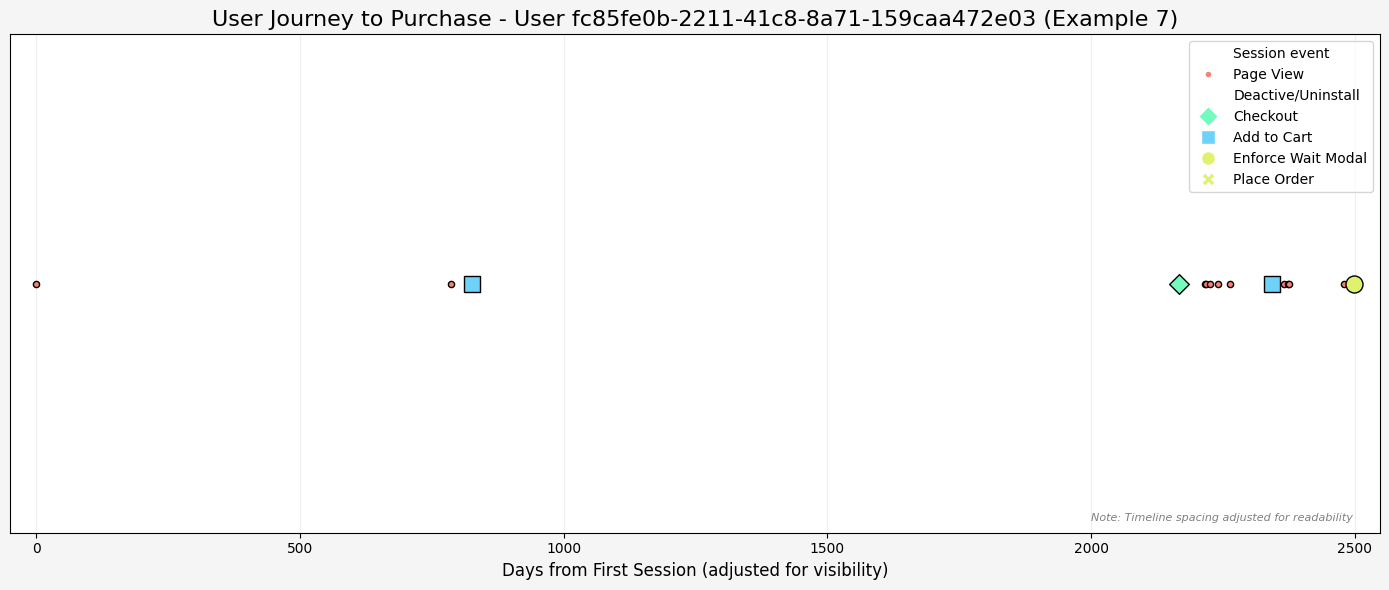

/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_32171/2930677612.py:66: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


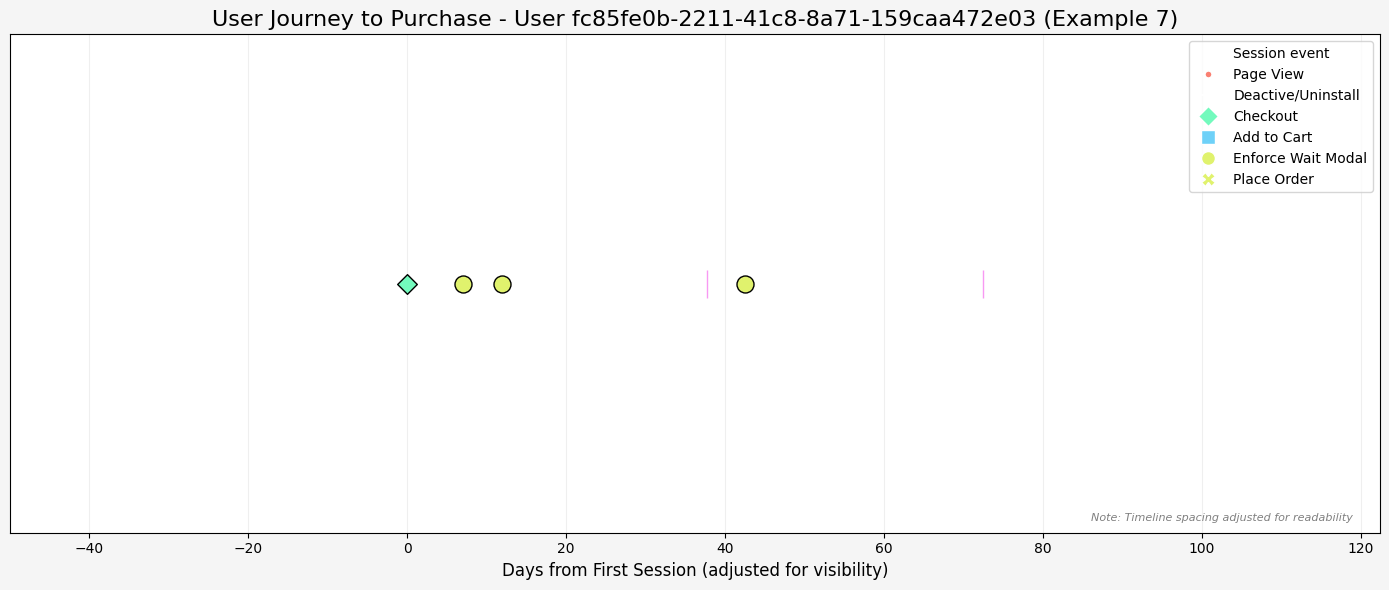

/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_32171/2930677612.py:66: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


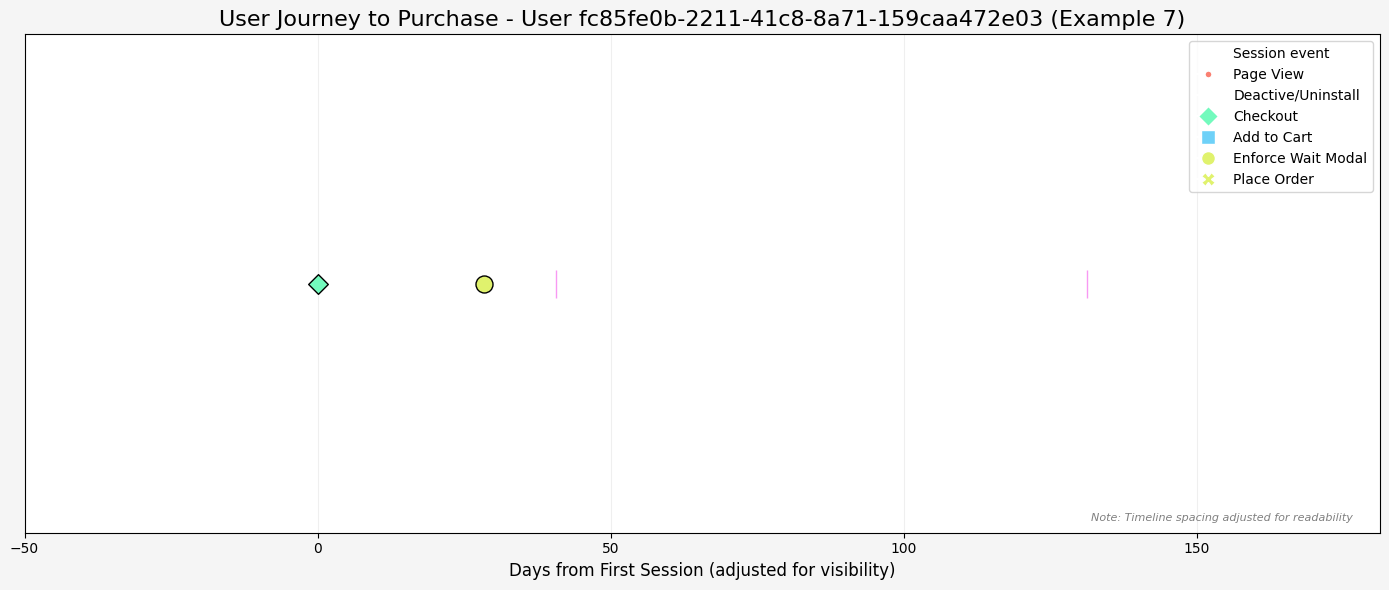

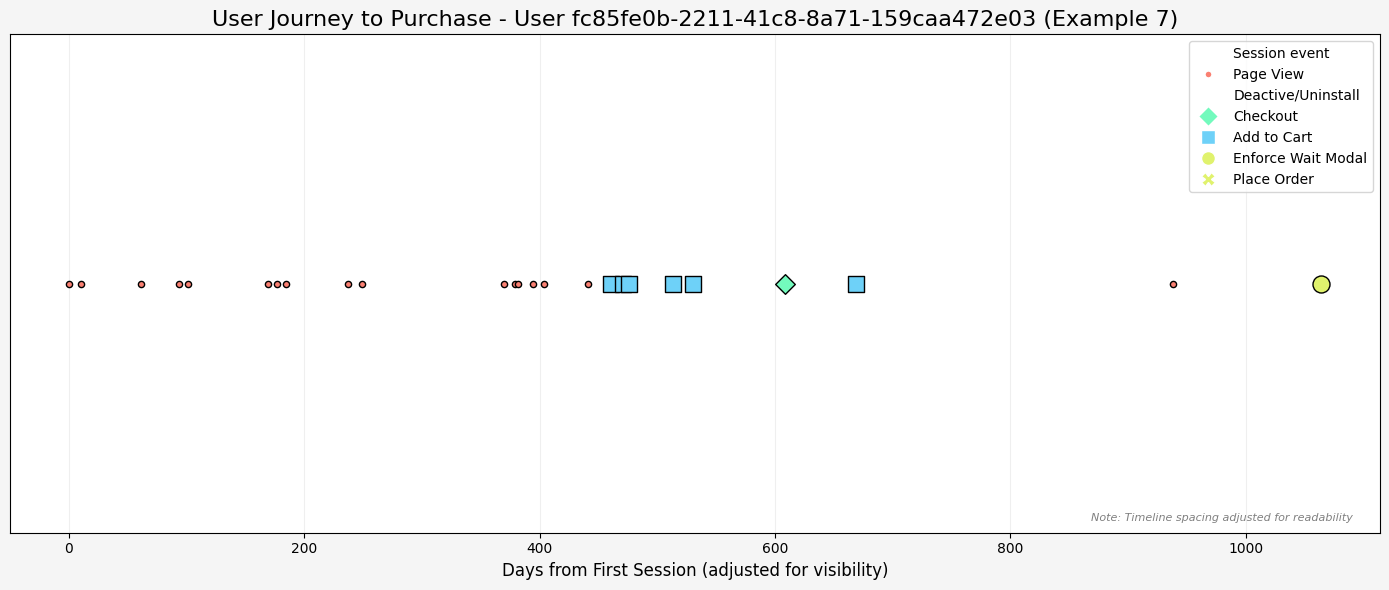

/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_32171/2930677612.py:66: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


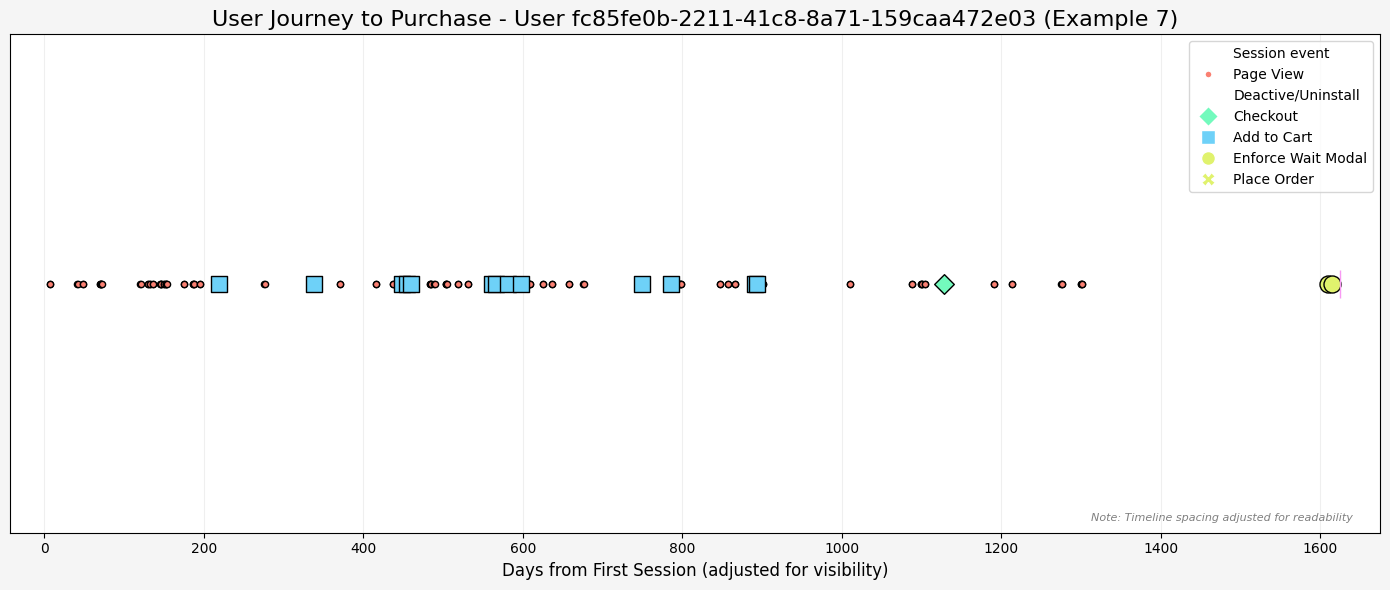

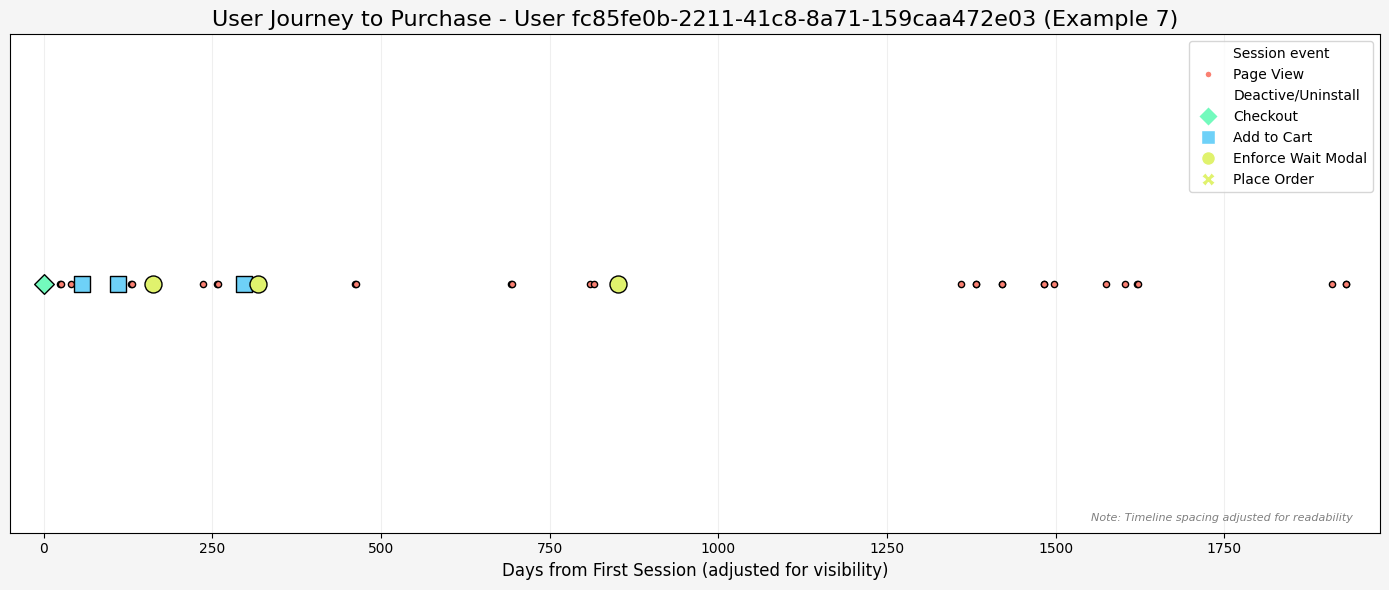

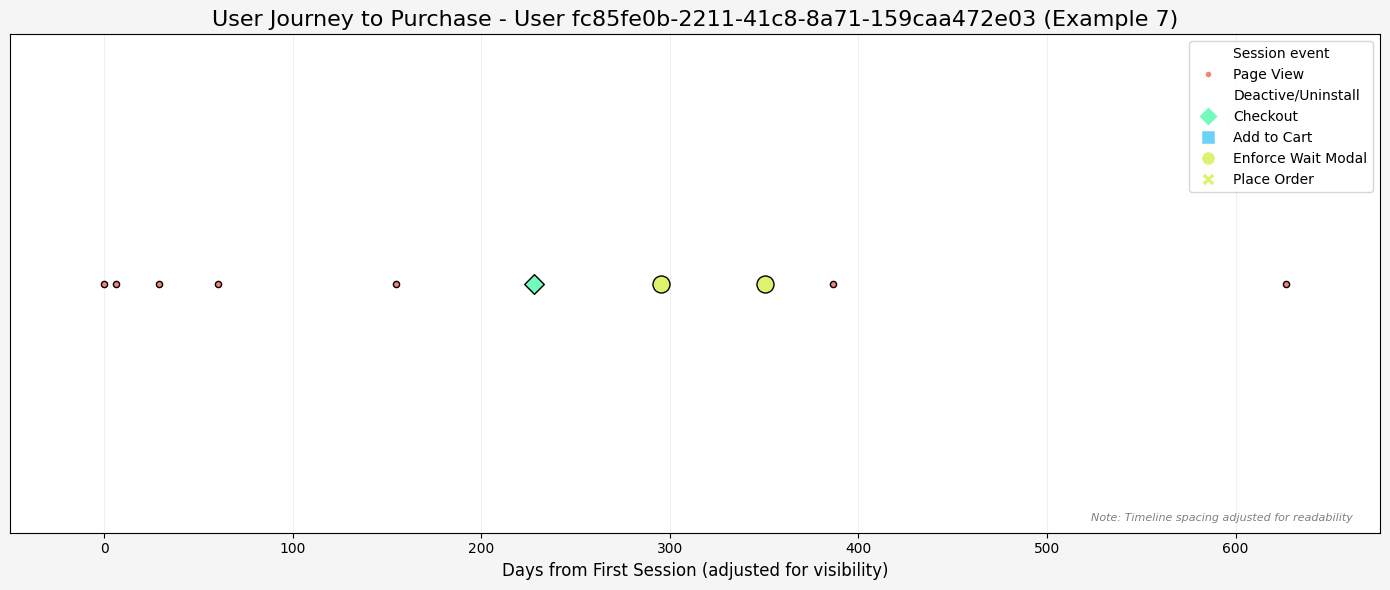

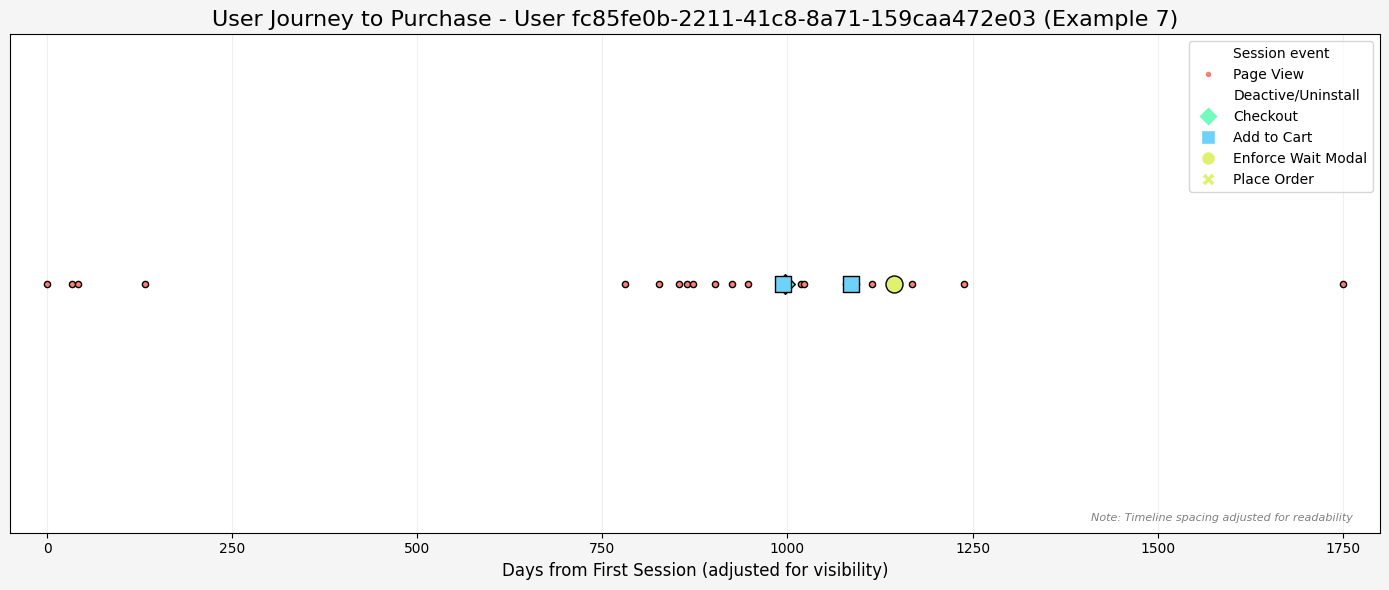

/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_32171/2930677612.py:66: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


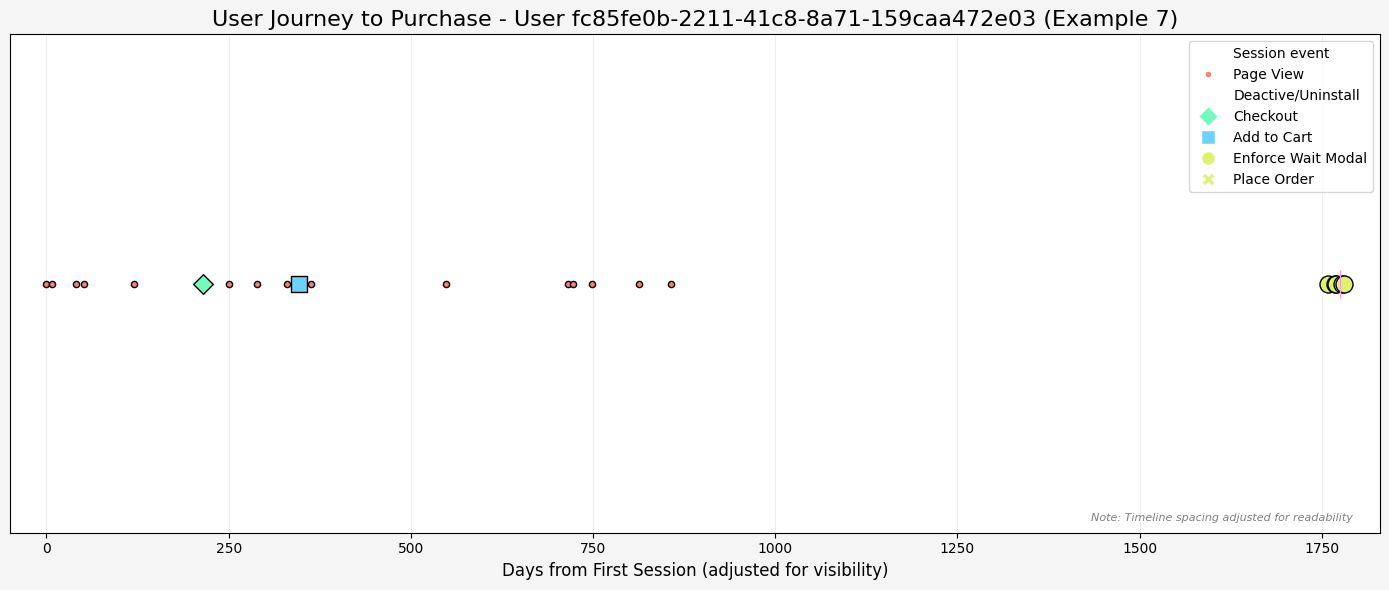

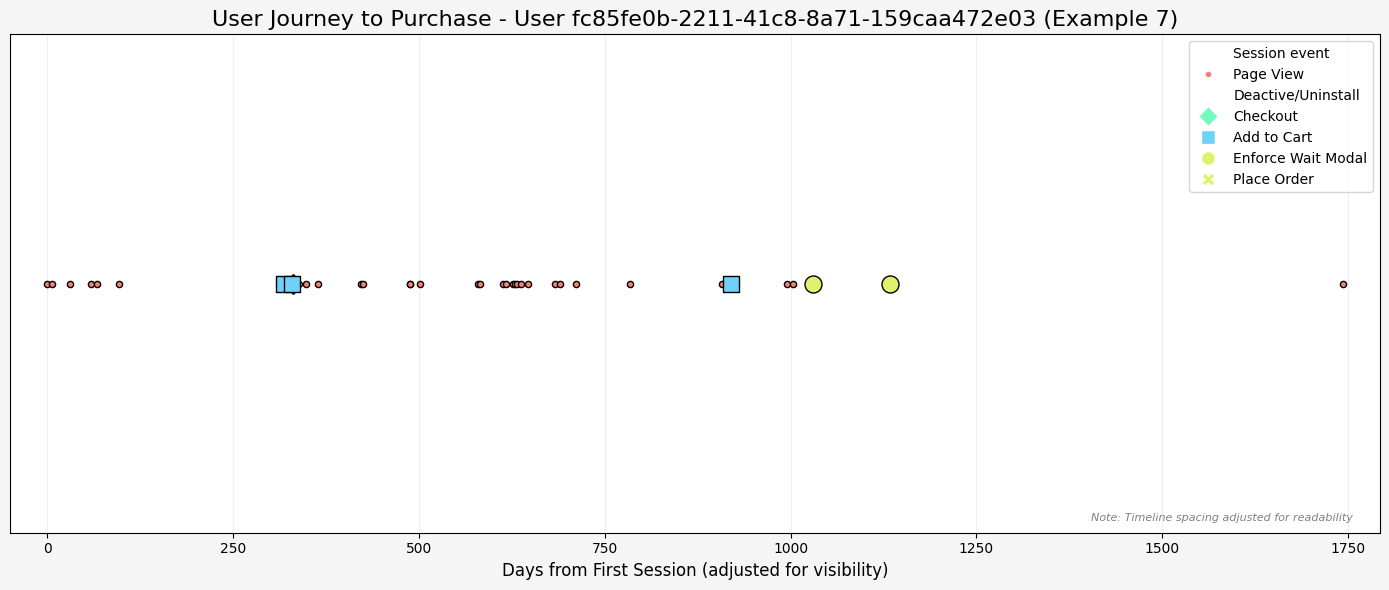

In [98]:
for buying_session in buying_session_ids:
    # Prepare data for visualization
    timeline_data = []
    session_df = df[df['session_id'] == buying_session].copy()
    for _, session in session_df.iterrows():
        # Skip sessions with very low duration for better visualization
        # if session['duration_minutes'] < 0.1 and session['flow_category'] == 'Just Looking':
        #     continue

        # Calculate time from first session
        time_from_first = (session['timestamp'] - session_df['timestamp'].min()).total_seconds()

        # Determine session type color and marker
        if session['type'] == 'enforce_wait_modal_shown':
            color = colors[4]  # Purchase event
            marker = 'o'
            size = 150
            zorder = 10
        elif session['type'] == 'add-to-cart':
            color = colors[3]  # Add to cart + checkout
            marker = 's'
            size = 120
            zorder = 8
        elif session['type'] == 'checkout':
            color = colors[2]  # Add to cart
            marker = 'D'
            size = 100
            zorder = 6
        elif session['type'] == 'active' or session['type'] == 'uninstall':
            color = colors[1]  # Checkout
            marker = '|'
            size = 400
            zorder = 12
        elif session['type'] == 'page-view':
            color = colors[0]  # Just looking
            marker = '.'
            size = 80
            zorder = 5
        elif session['type'] == 'place-order':
            color = colors[0]
            marker = 'X'
            size = 80
            zorder = 5
        else: # 'place-order'
            """  """
            continue
            
        timeline_data.append({
            'session_id': session['session_id'],
            'time': time_from_first,
            'color': color,
            'marker': marker,
            'size': size,
            'zorder': zorder
        })
    # Adjust x-coordinates for better spacing when events are too close
    # Sort by time
    timeline_data.sort(key=lambda x: x['time'])
    
    # Adjust positions
    # Create the timeline visualization
    plt.figure(figsize=(14, 6), facecolor=facecolor)
    
    # Plot each session as a point
    for event in timeline_data:
        plt.scatter(
            event['time'], 
            0.5,  # Fixed y-position for timeline
            color=event['color'],
            s=event['size'],
            marker=event['marker'],
            zorder=event['zorder'],
            edgecolors='black',
            linewidth=1
        )
        
        # Add flow category label above point with more vertical space
        # Do this for all sessions, including purchase sessions
        """ plt.text(
            session['time_days'],
            0.65,  # Increased vertical position
            session['flow_category'],
            rotation=45,
            ha='center',
            va='bottom',
            fontsize=10,  # Slightly larger font
            fontweight='bold' if not session['has_purchase'] else 'normal',  # Normal weight for purchase events
            color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor=session['color'], boxstyle='round,pad=0.3'),
            zorder=session['zorder']
        ) """
    
        
        # Add duration label below point
        """ plt.text(
            session['time_days'],
            0.35,  # Lower position for better spacing
            f"{session['duration_minutes']:.1f} min",
            ha='center',
            va='top',
            fontsize=9,
            color='black',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'),
            zorder=session['zorder']
        ) """
        
        # Add time from first session as a more subtle label
        """ if session['time_days'] > 0.1:  # Skip for first session
            plt.text(
                session['time_days'],
                0.2,  # Lower position
                f"Day {session['time_days']:.1f}",
                ha='center',
                va='top',
                fontsize=8,
                color='gray',
                zorder=session['zorder'] - 1
            ) """
    
    # Connect points with lines - now dotted for better aesthetics
    """     times = [session['time_days'] for session in timeline_data]
    plt.plot(times, [0.5] * len(times), 'k--', alpha=0.4, zorder=1, linewidth=1.5)
    
    # Add clear markers for timeline scale
    if max(times) > 3:  # Only add markers if timeline is long enough
        day_markers = list(range(0, int(max(times)) + 2, 2))  # Every 2 days
        for day in day_markers:
            if day > 0:  # Skip day 0
                plt.axvline(x=day, color='lightgray', linestyle=':', alpha=0.5, zorder=0)
     """
    # Add annotations for first session only - purchase annotation is handled by the text label
    """ if len(timeline_data) > 0:
        plt.annotate('First Session', 
                    (timeline_data[0]['time_days'], 0.5),
                    xytext=(timeline_data[0]['time_days'], 0.25),
                    arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
                    ha='center', va='top', fontsize=10, fontweight='bold')
     """
    # Set up the plot with improved aesthetics
    plt.title(f'User Journey to Purchase - User {user_id} (Example {i+1})', fontsize=16)
    plt.xlabel('Days from First Session (adjusted for visibility)', fontsize=12)
    plt.yticks([])
    plt.grid(True, axis='x', alpha=0.2)


    
    
    # Add padding to x-axis for better appearance
    plt.xlim(left=timeline_data[0]['time'] - 50, right=timeline_data[-1]['time'] + 50)
    plt.ylim(0, 1)
    
    # Add a legend with improved positioning
    legend_elements = [
        plt.Line2D([0], [0], marker='.', color='w', markerfacecolor=colors[0], markersize=10, label='Page View'),
        plt.Line2D([0], [0], marker='|', color='w', markerfacecolor=colors[1], markersize=10, label='Deactive/Uninstall'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[2], markersize=10, label='Checkout'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[3], markersize=10, label='Add to Cart'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4], markersize=10, label='Enforce Wait Modal'),
        plt.Line2D([0], [0], marker='X', color='w', markerfacecolor=colors[4], markersize=10, label='Place Order')
    ]
    plt.legend(handles=legend_elements, loc='upper right', title='Session event')
    
    # Add journey stats
    #original_days = (purchase_time - user_sessions['start_time'].min()).total_seconds() / (60*60*24)
    """ stats_text = f"Total Sessions: {len(timeline_data)}\n"
    stats_text += f"Actual Days to Purchase: {original_days:.1f}\n"
    stats_text += f"Sessions before Purchase: {user_journey['total_sessions_before_purchase']}\n"
    stats_text += f"Just Looking Sessions: {user_journey['pre_purchase_just_looking_count']}\n"
    stats_text += f"Add to Cart Sessions: {user_journey['pre_purchase_add_to_cart_count']}\n"
    stats_text += f"Checkout Sessions: {user_journey['pre_purchase_checkout_count']}"
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
                va='top', ha='left', fontsize=10) """
    
    # Add note about adjusted timeline
    plt.text(0.98, 0.02, "Note: Timeline spacing adjusted for readability", 
                transform=plt.gca().transAxes,
                va='bottom', ha='right', fontsize=8, fontstyle='italic', color='gray')
    
    plt.tight_layout()
    plt.show()